# **Кошкарев 20223**

# Сама лаба

Рабочий конвертер в PDF
https://htmtopdf.herokuapp.com/ipynbviewer/

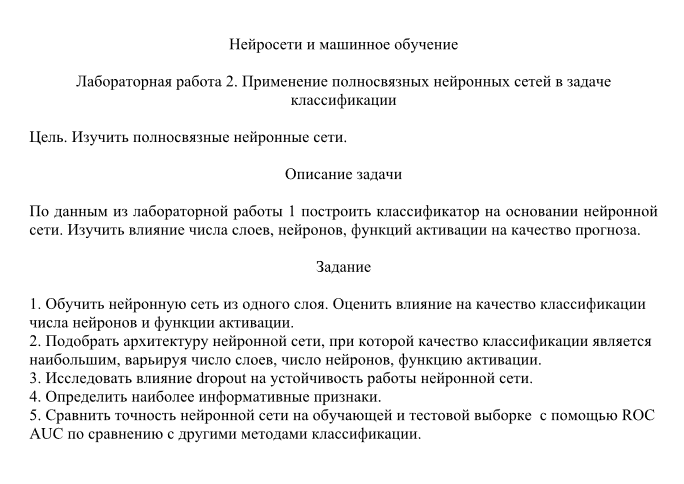

гистограмма пол - магазин автоматизировать

магазин удалить - сделать 50 колонок и фигачить туда сумму

если не покупал в магазе - 0

цикл по всем атрибутам и проверить гипотеза об однородности?

# ПОДКЛЮЧЕНИЕ GPU

тыкнуть сюда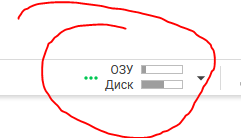

потом сюда

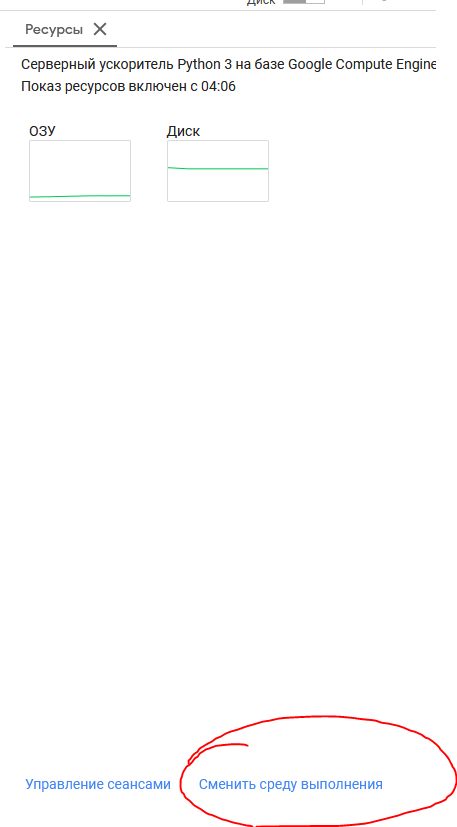

потом сюда

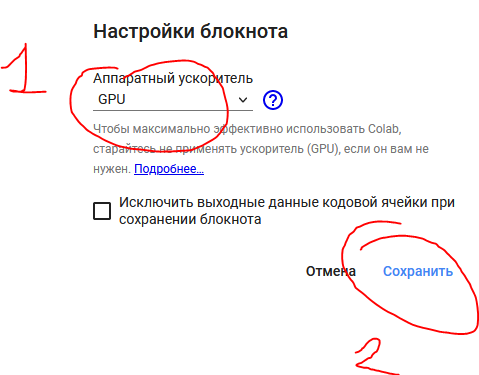

In [1]:
import time
start = time.time()

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(str(device))
# if str(device) != "cuda:0":
#     raise ValueError("Not GPU")

cuda:0


# kaggle
https://www.kaggle.com/c/python-and-analyze-data-final-project/submit

In [3]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_auc_score

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from tqdm._tqdm_notebook import tqdm_notebook

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  app.launch_new_instance()


In [4]:
%%html
<marquee style='width: 30%; color: blue;'><b>best lab ever!</b></marquee>

In [5]:
def printt(data):
  pd.set_option('display.max_rows', 9999)
  pd.set_option('display.max_columns', 9999)
  display(data)
  pd.set_option('display.max_rows', 20)
  pd.set_option('display.max_columns', 20)

In [6]:
timing = pd.DataFrame(columns=['what', 'time(sec)', 'delta(min)'])

def timing_snapshot(text):
  ttt = time.time()-start
  if len(timing) == 0:
    delta = 0
  else:
    delta = ttt - timing.loc[len(timing)-1]['time(sec)']
  timing.loc[len(timing)] = [text, ttt, round(delta/60, 1)]
  # display(timing)

In [7]:
# for _ in range(0, 100):
#   timing_snapshot('begin')
# timing

In [8]:
timing_snapshot('begin')

In [9]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

In [59]:
def printt(data):
  pd.set_option('display.max_rows', None)
  pd.set_option('display.max_columns', None)
  display(data)
  pd.set_option('display.max_rows', 20)
  pd.set_option('display.max_columns', 20)

In [11]:
from google.colab import files
from google.colab import drive

In [12]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим наборы данных

* transactions.csv - таблица содержит историю транзакций клиентов банка за один год и три месяца.
* gender_train.csv - таблица содержит информацию по полу для части клиентов, для которых он известен.
* tr_mcc_codes.csv - таблица содержит описание mcc-кодов транзакций.
* tr_types.csv - таблица содержит описание типов транзакций.
*gender_test_kaggle_sample_submission.csv - пример файла для загрузки решения.

In [13]:
dir = '/content/drive/MyDrive/nmo/01/'
tr_mcc_codes = pd.read_csv(dir+'tr_mcc_codes.csv', sep=';',index_col='mcc_code')
tr_types = pd.read_csv(dir+'tr_types.csv', sep=';', index_col='tr_type')
gender_train = pd.read_csv(dir+'gender_train.csv',index_col='customer_id')
gender_test = pd.read_csv(dir+'gender_test_kaggle_sample_submission.csv',index_col='customer_id')
transactions = pd.read_csv(dir+'transactions.csv',index_col='customer_id')
# transactions = pd.read_csv(dir+'transactions.zip',index_col='customer_id')
timing_snapshot('load files')

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
transactions['log_amount'] = np.sign(transactions['amount'])*np.log10(np.abs(transactions['amount'])) 
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner') 

In [15]:
# transactions_train.isna().sum()

Так как суммы расходов могут быть очень большими, то выполним преобразование - прологарифмируем суммы расходов и доходов, сохраняя знак

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(tr_mcc_codes)
#transactions_train = transactions_train.loc[transactions_train['mcc_code']==5977]

                                            mcc_description
mcc_code                                                   
742                                     Ветеринарные услуги
1711      Генеральные подрядчики по вентиляции, теплосна...
1731                            Подрядчики по электричеству
1799      Подрядчики, специализированная торговля — нигд...
2741               Разнообразные издательства/печатное дело
3000                                Авиалинии, авиакомпании
3351                        Агентства по аренде автомобилей
3501                         Жилье — отели, мотели, курорты
4111      Транспортировка — пригородные и локальные сезо...
4112                        Пассажирские железные перевозки
4121                                       Лимузины и такси
4131                                       Автобусные линии
4214      Агентства по автотранспортным перевозкам, мест...
4215      Услуги курьера — по воздуху и на земле, агентс...
4411                                    

In [17]:
tr_types

,tr_description
tr_type,
3200,Плата за предоставление услуг посредством моби...
3210,Плата за предоставление отчета по счету карты ...
3800,Плата за обслуживание банковской карты (за пер...
4000,Плата за получение наличных в Сбербанке
4001,Плата за получение наличных в Сбербанке (в дру...
...,...
2990,Списание по требованию
2992,Списание средств для погашения задолженности п...
3001,Комиссия за обслуживание ссудного счета


Сформируем базовые переменные по каждому клиенту. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:

* минимум
* максимум
* среднее
* медиана
* среднеквадратичное отклонение
* количество


In [18]:
import re
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = (~df['hour'].between(6, 22)).astype(int)

In [19]:
timing_snapshot('extract_features')

In [20]:
def features_creation_basic2(x): 
    features = []
    base_feature = 'log_amount'
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x[base_feature]>0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x[base_feature]<0][base_feature].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    
    # result = x.groupby('mcc_code')['log_amount'].mean().fillna(0)
    result = x.groupby('mcc_code')['log_amount'].mean()
    result.index = result.index.map(lambda e: 'mcc_code_mean' + str(e))
    features.append(result)
 
    return pd.concat(features)

In [21]:
tqdm_notebook.pandas(desc="Progress:")
data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic2).unstack()
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic2).unstack()

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

Progress::   0%|          | 0/3600 [00:00<?, ?it/s]

In [22]:
timing_snapshot('features_creation')

In [23]:
all_features = list(data_train.columns)
all_features

['day_0',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'hour_0',
 'hour_1',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_2',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'mcc_code_mean1711',
 'mcc_code_mean1731',
 'mcc_code_mean1799',
 'mcc_code_mean2741',
 'mcc_code_mean3000',
 'mcc_code_mean3351',
 'mcc_code_mean3501',
 'mcc_code_mean4111',
 'mcc_code_mean4112',
 'mcc_code_mean4121',
 'mcc_code_mean4131',
 'mcc_code_mean4214',
 'mcc_code_mean4215',
 'mcc_code_mean4411',
 'mcc_code_mean4511',
 'mcc_code_mean4722',
 'mcc_code_mean4784',
 'mcc_code_mean4789',
 'mcc_code_mean4812',
 'mcc_code_mean4814',
 'mcc_code_mean4816',
 'mcc_code_mean4829',
 'mcc_code_mean4899',
 'mcc_code_mean4900',
 'mcc_code_mean5013',
 'mcc_code_mean5039',
 'mcc_code_mean5044',
 'mcc_code_mean5045',
 'mcc_code_mean5047',
 'mcc_code_mea

In [24]:
data_train.fillna(0, inplace=True)
data_test.fillna(0, inplace=True)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(data_train)

data_train = pd.DataFrame(scaler.transform(data_train), index=data_train.index, 
                          columns=data_train.columns)
data_test = pd.DataFrame(scaler.transform(data_test), index=data_test.index, 
                          columns=data_test.columns)

Сформируем вектор целевой переменной

In [26]:
target = data_train.join(gender_train, how='inner')['gender']

---

In [27]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X_train, X_val, y_train, y_val = train_test_split(data_train, target, test_size=0.30, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)



Делаем менеджера сети

In [28]:
def get_f_name(f):
  arr = str(f).split(' ')
  name = arr[1]
  if name == 'method':
    name = arr[2]
  return name #  + f'<{str(f)}>'

In [29]:
import torch.nn.functional as F
import torch
for f in [F.relu, F.elu, torch.sigmoid, F.softsign, torch.tanh, F.hardshrink]:
  print(get_f_name(f))

relu
elu
sigmoid
softsign
tanh
hardshrink


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_size, 
                 num_layers=1, 
                 layer_size=100,
                 activation=F.relu):
        super().__init__()
        
        self.input_layer = nn.Linear(input_size, layer_size)
        self.layers = []
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))

        self.layers = nn.ModuleList(self.layers)
        self.output_layer = nn.Linear(layer_size, 1)
        
        self.activation = activation

    def forward(self, input):
        output = self.activation(self.input_layer(input))
        for layer in self.layers:
            output = self.activation(layer(output))
        output = self.output_layer(output)
        
        return output

    def __str__(self):
        return f'input_size={self.input_size}; num_layers={num_layers}; layer_size={layer_size}; f={get_f_name(activation)}'

In [31]:
import torch.optim as torch_optim

def train_model(model, 
                train_dataloader, 
                val_dataloader,
                device, 
                num_epochs = 10,
                lr = 10e-5,
                show=True):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch_optim.Adam(parameters, lr=lr)

    loss_function = nn.BCEWithLogitsLoss()

    train_losses = []
    train_roc_aucs = []
    val_losses = []
    val_roc_aucs = []
    for e in range(num_epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_roc_auc = 0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X_batch)
            
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_roc_auc += roc_auc.item()

        model.eval()
            
        epoch_val_loss = 0
        epoch_val_roc_auc = 0

        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())

            epoch_val_loss += loss.item()
            epoch_val_roc_auc += roc_auc.item()
        
        train_losses.append(epoch_train_loss / len(train_dataloader))
        train_roc_aucs.append(epoch_train_roc_auc / len(train_dataloader))
        val_losses.append(epoch_val_loss / len(val_dataloader))
        val_roc_aucs.append(epoch_val_roc_auc / len(val_dataloader))

    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        x = range(len(train_losses))
        ax1.plot(x, train_losses, label='Train')
        ax1.plot(x, val_losses, label='Val')
        # ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(x, train_roc_aucs, label='Train')
        ax2.plot(x, val_roc_aucs, label='Val')
        # ax2.set_title('Metric (ROC AUC)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('ROC AUC')
        ax2.legend()
        plt.show()

    return np.array(val_roc_aucs).max()

In [32]:
def test_layer_size(layer_size, num_layers=1, activation=F.relu, num_epochs=10, show=True):
   
    model = NeuralNetwork(X_train.shape[1], num_layers=num_layers, layer_size=layer_size, activation=activation)
    model.to(device)
    best_metric = train_model(model, train_dataloader, val_dataloader, device, num_epochs=num_epochs, show=show)
    if show:
        print(f"Нейронов в слое: {layer_size}")
        print(f"Кол-во слоёв: {num_layers}")
        print(f"Функция активации: {get_f_name(activation)}")
        print(f"Лучший результат на валидации: {best_metric}")
    return best_metric

In [33]:
timing_snapshot('before exp')

In [34]:
def timing_snapshot_extra(experiment, num_layers, layer_size, num_epochs, f):
  s = f'{experiment}: num_layers={num_layers}; layer_size={layer_size}; num_epochs={num_epochs};f={get_f_name(f)}'
  timing_snapshot(s)

# Эксперимент 1
Фиксируем 
- кол-во слоёв
- кол-во эпох
- функцию активации

Меняем
- кол-во нейронов в слое 


In [35]:
from tqdm import tqdm_notebook

In [36]:
results = pd.DataFrame(columns=['layer_size', 'layer_count', 'f_activation', 'num_epochs', 'roc_auc_score', 'experiment', 'time(sec)', 'delta(min)'])

In [37]:
def add_timing():
  ttt = time.time()-start
  if len(results) == 0:
    delta = 0
  else:
    delta = ttt - results.loc[len(results)-1]['time(sec)']
  return ttt, round(delta/60, 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/8 [00:00<?, ?it/s]

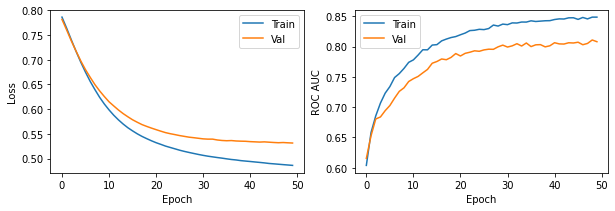

Нейронов в слое: 1
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8110078926354166

---



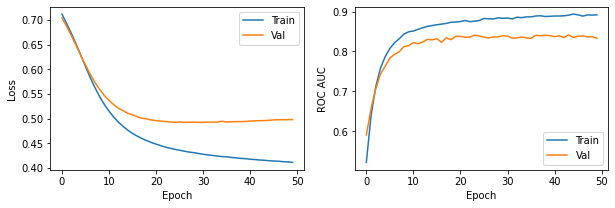

Нейронов в слое: 5
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8413754783823583

---



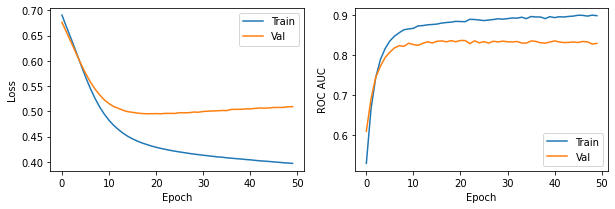

Нейронов в слое: 10
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8366126320020985

---



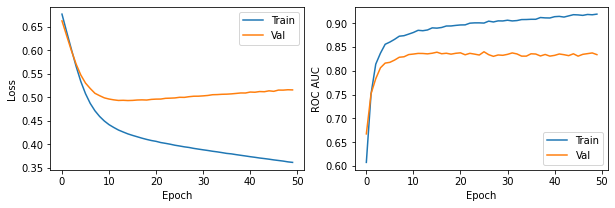

Нейронов в слое: 25
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8398801653970808

---



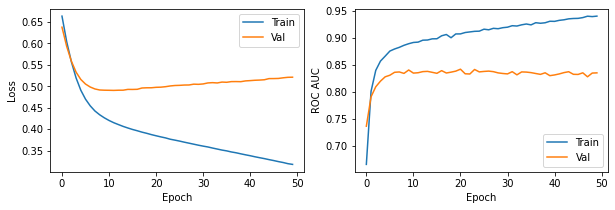

Нейронов в слое: 50
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8419800979876778

---



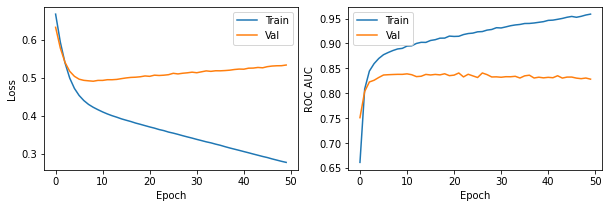

Нейронов в слое: 100
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8408037386797826

---



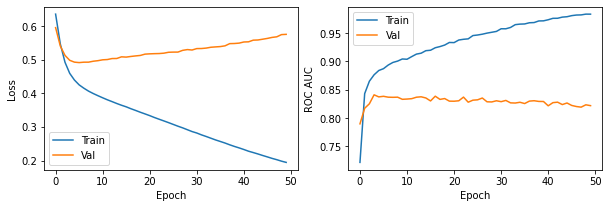

Нейронов в слое: 250
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.841180312786313

---



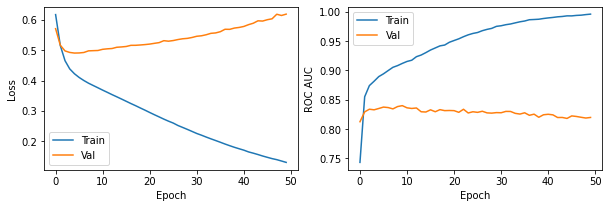

Нейронов в слое: 500
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8400117393243429

---



In [38]:
experiment_index = 1
num_epochs = 50
ff = F.relu
layer_count = 1
# layer_sizes = [1, 5]
layer_sizes = [1, 5, 10, 25, 50, 100, 250, 500]
for layer_size in tqdm_notebook(layer_sizes):
  roc_auc = test_layer_size(layer_size, activation=ff, num_epochs=num_epochs, num_layers=layer_count);
  s, m = add_timing()
  results.loc[len(results)] = [layer_size, layer_count, get_f_name(ff), num_epochs, roc_auc, experiment_index, s, m]
  timing_snapshot_extra('exp 1', layer_count, layer_size, num_epochs, ff)
  print('\n---\n')

In [39]:
def get_result_info(df, experiment_index=None):
  if experiment_index is None:
    return df.sort_values(by=['roc_auc_score'], ascending=False)
  else:
    return df.sort_values(by=['roc_auc_score'], ascending=False).loc[:, df.columns != 'experiment'].loc[df['experiment']==experiment_index]

In [40]:
get_result_info(results, 1)

,layer_size,layer_count,f_activation,num_epochs,roc_auc_score,time(sec),delta(min)
4,50,1,relu,50,0.841980,397.478233,0.7
1,5,1,relu,50,0.841375,267.084850,0.7
6,250,1,relu,50,0.841180,485.457546,0.7
5,100,1,relu,50,0.840804,441.343115,0.7
7,500,1,relu,50,0.840012,529.684844,0.7
3,25,1,relu,50,0.839880,353.618654,0.7
2,10,1,relu,50,0.836613,310.698982,0.7
0,1,1,relu,50,0.811008,223.490084,0.0


Результат похож на распределение Гаусса.
Мало - плохо, много - плохо. А в серединке - самый сок

Выделяется 1 нейрон с 1 слоем. Это очень похоже на линейную регрессию.

Много нейронов не даёт улучшения

In [41]:
timing_snapshot('exp 1 finished')

# Эксперимент 2
Фиксируем 
- кол-во нейронов в слое 
- кол-во эпох
- кол-во слоёв

Меняем
- функцию активации


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/6 [00:00<?, ?it/s]

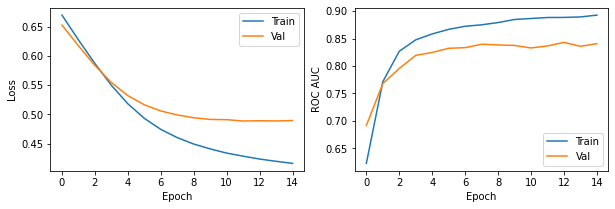

Нейронов в слое: 30
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.842940140240842

---



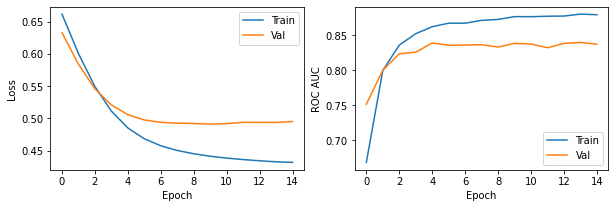

Нейронов в слое: 30
Кол-во слоёв: 1
Функция активации: elu
Лучший результат на валидации: 0.8394465874164309

---



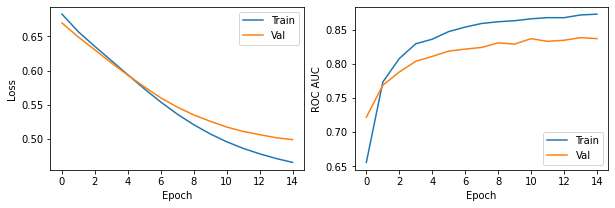

Нейронов в слое: 30
Кол-во слоёв: 1
Функция активации: sigmoid
Лучший результат на валидации: 0.8381547921165371

---



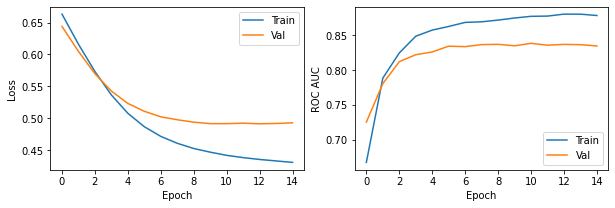

Нейронов в слое: 30
Кол-во слоёв: 1
Функция активации: softsign
Лучший результат на валидации: 0.838449871620301

---



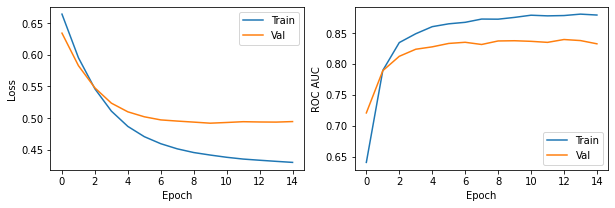

Нейронов в слое: 30
Кол-во слоёв: 1
Функция активации: tanh
Лучший результат на валидации: 0.8395296893292116

---



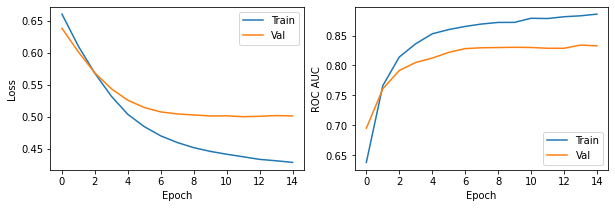

Нейронов в слое: 30
Кол-во слоёв: 1
Функция активации: hardshrink
Лучший результат на валидации: 0.8340697000470182

---



In [42]:
experiment_index = 2
num_epochs = 15
layer_size = 30
layer_count = 1
functions = [F.relu, F.elu, torch.sigmoid, F.softsign, torch.tanh, F.hardshrink] 
for fff in tqdm_notebook(functions):
  roc_auc = test_layer_size(layer_size, activation=fff, num_epochs=num_epochs, num_layers=layer_count);
  s, m = add_timing()
  results.loc[len(results)] = [layer_size, layer_count, get_f_name(fff), num_epochs, roc_auc, experiment_index, s, m]
  timing_snapshot_extra('exp 2', layer_count, layer_size, num_epochs, fff)
  print('\n---\n')

In [43]:
get_result_info(results, 2)

,layer_size,layer_count,f_activation,num_epochs,roc_auc_score,time(sec),delta(min)
8,30,1,relu,15,0.842940,543.488536,0.2
12,30,1,tanh,15,0.839530,598.025650,0.2
9,30,1,elu,15,0.839447,557.295636,0.2
11,30,1,softsign,15,0.838450,584.483933,0.2
10,30,1,sigmoid,15,0.838155,570.528243,0.2
13,30,1,hardshrink,15,0.834070,611.650332,0.2


Вывод: ф-ии ведут себя примерно одинаково, но relu чуть лучше. Это заметно на маленьком кол-ве эпох relu лучше обучается

In [44]:
timing_snapshot('exp 2 finished')

# Эксперимент 3 
Фиксируем 
- кол-во нейронов в слое 
- кол-во эпох
- функцию активации

Меняем
- кол-во слоёв

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/7 [00:00<?, ?it/s]

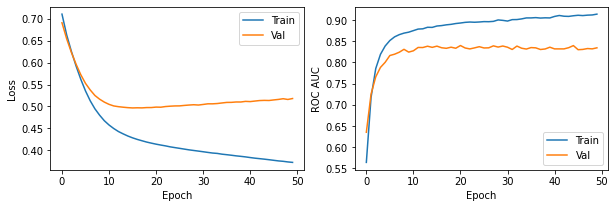

Нейронов в слое: 20
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8400026631797427

---



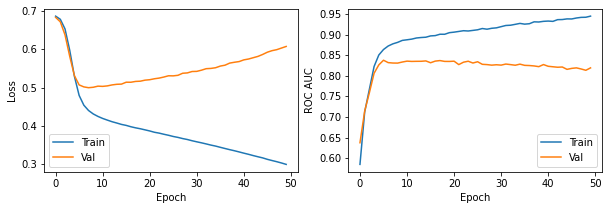

Нейронов в слое: 20
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.8376361616019163

---



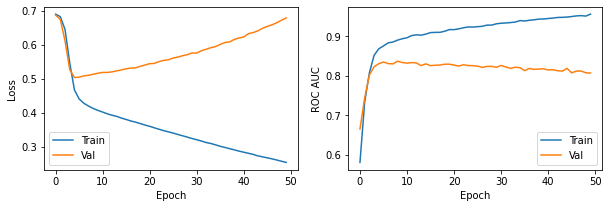

Нейронов в слое: 20
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.8372856708970602

---



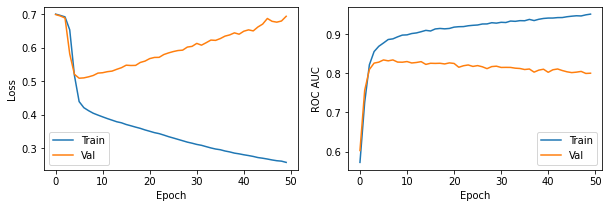

Нейронов в слое: 20
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.8345160242982095

---



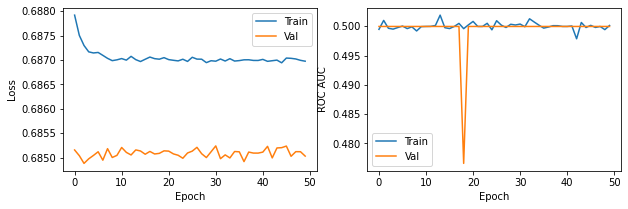

Нейронов в слое: 20
Кол-во слоёв: 25
Функция активации: relu
Лучший результат на валидации: 0.5

---



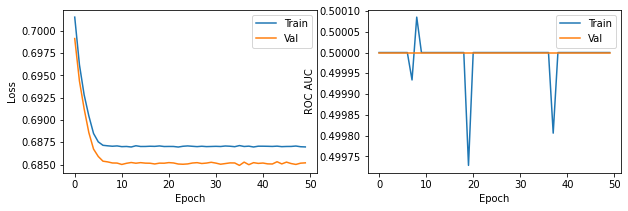

Нейронов в слое: 20
Кол-во слоёв: 50
Функция активации: relu
Лучший результат на валидации: 0.5

---



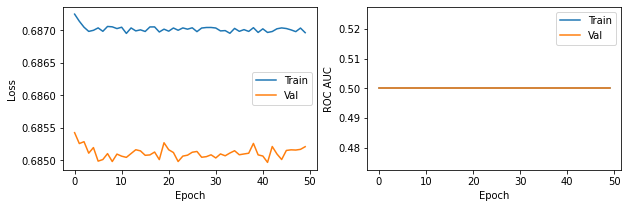

Нейронов в слое: 20
Кол-во слоёв: 100
Функция активации: relu
Лучший результат на валидации: 0.5

---



In [45]:
experiment_index = 3
num_epochs = 50
layer_size = 20
layer_counts = [1, 3, 5, 10, 25, 50, 100] 
function = F.relu
for layer_count in tqdm_notebook(layer_counts):
  roc_auc = test_layer_size(layer_size, activation=function, num_epochs=num_epochs, num_layers=layer_count)
  s, m = add_timing()
  results.loc[len(results)] = [layer_size, layer_count, get_f_name(function), num_epochs, roc_auc, experiment_index, s, m]
  timing_snapshot_extra('exp 3', layer_count, layer_size, num_epochs, function)
  print('\n---\n')

Вывод: большое кол-во слоёв не даёт заметный прирост на таком кол-ве эпох

In [46]:
get_result_info(results, 3)

,layer_size,layer_count,f_activation,num_epochs,roc_auc_score,time(sec),delta(min)
14,20,1,relu,50,0.840003,656.154250,0.7
15,20,3,relu,50,0.837636,709.687220,0.9
16,20,5,relu,50,0.837286,771.609177,1.0
17,20,10,relu,50,0.834516,855.425527,1.4
18,20,25,relu,50,0.500000,1002.527962,2.5
19,20,50,relu,50,0.500000,1258.864468,4.3
20,20,100,relu,50,0.500000,1732.267257,7.9


Вывод - увеличение кол-ва слоёв прирост

In [47]:
timing_snapshot('exp 3 finished')

# Эксперимент 4 
Фиксируем 
- функцию активации

Меняем
- кол-во слоёв
- кол-во нейронов в слое 
- кол-во эпох


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

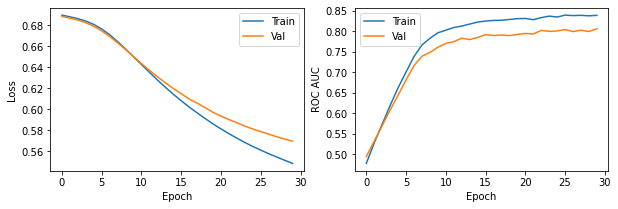

Нейронов в слое: 1
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8065826611986805

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

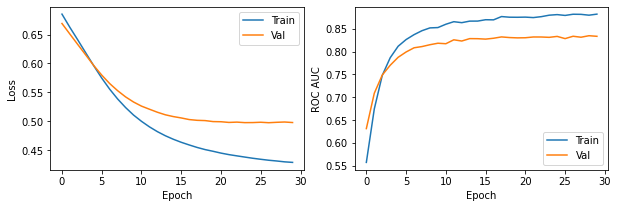

Нейронов в слое: 5
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8350253018513699

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

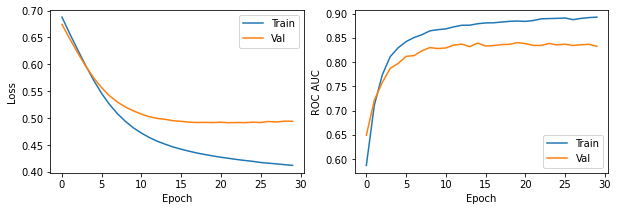

Нейронов в слое: 10
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8400177979629526

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

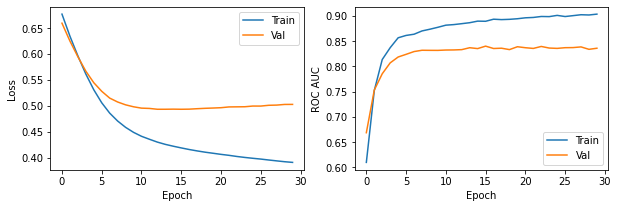

Нейронов в слое: 25
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.839952414514891

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

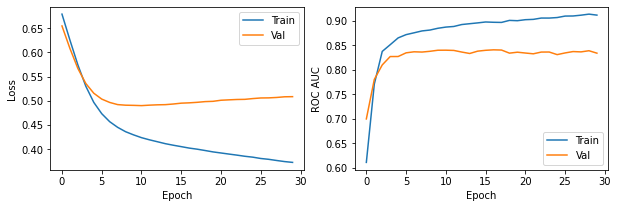

Нейронов в слое: 50
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8408340244721678

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

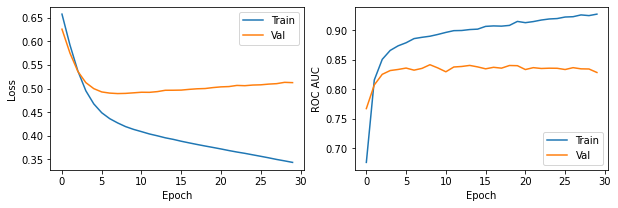

Нейронов в слое: 100
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8417743697513759

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

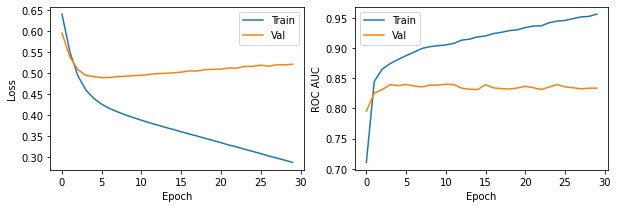

Нейронов в слое: 250
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8402561950986976

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

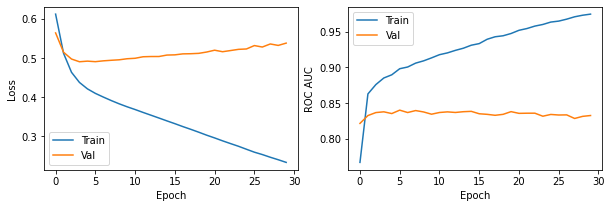

Нейронов в слое: 500
Кол-во слоёв: 1
Функция активации: relu
Лучший результат на валидации: 0.8400430303899019

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

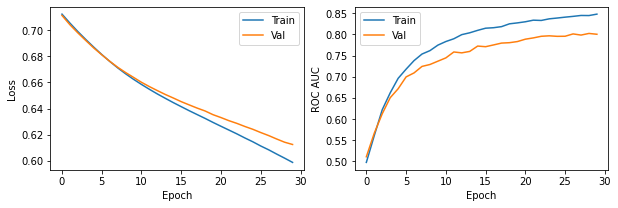

Нейронов в слое: 1
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.8021878755635865

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

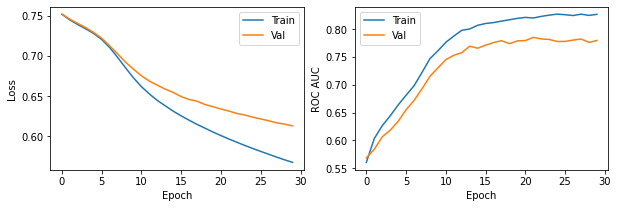

Нейронов в слое: 5
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.785122651344351

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

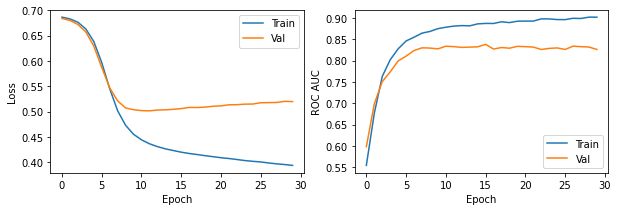

Нейронов в слое: 10
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.8379150789804702

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

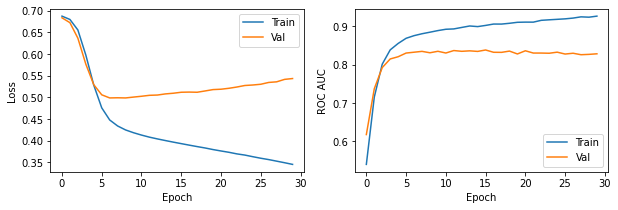

Нейронов в слое: 25
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.838207134756053

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

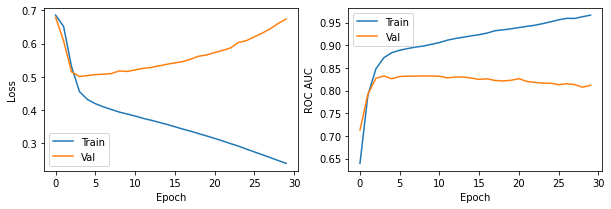

Нейронов в слое: 50
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.8324053865076756

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

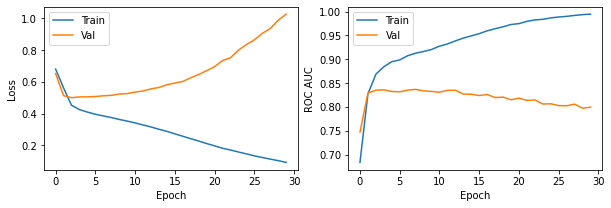

Нейронов в слое: 100
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.8368923510534432

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

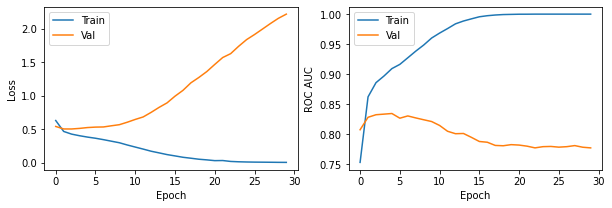

Нейронов в слое: 250
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.8343113537570298

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

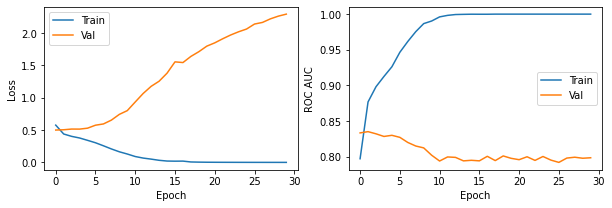

Нейронов в слое: 500
Кол-во слоёв: 3
Функция активации: relu
Лучший результат на валидации: 0.8352531475801409

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

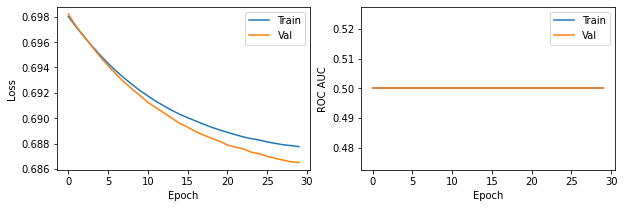

Нейронов в слое: 1
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.5

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

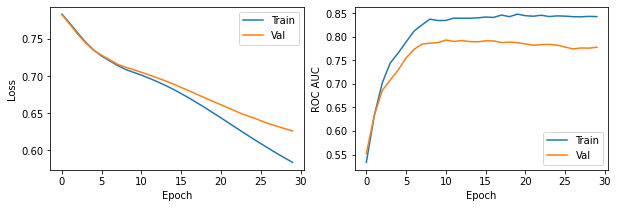

Нейронов в слое: 5
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.7932029555685058

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

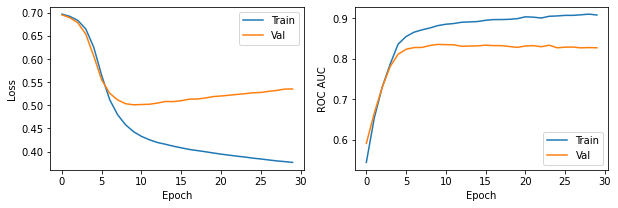

Нейронов в слое: 10
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.8354813686797168

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

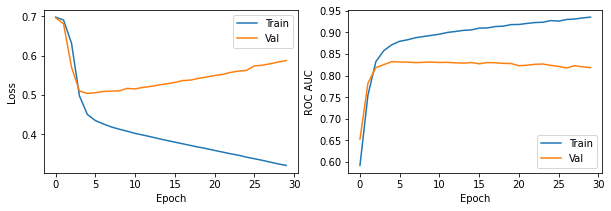

Нейронов в слое: 25
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.8321940343136024

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

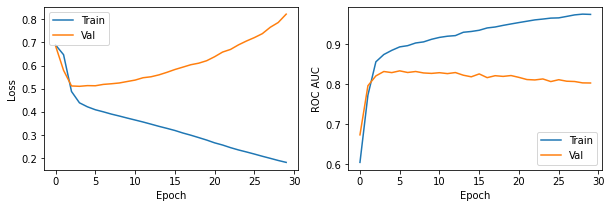

Нейронов в слое: 50
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.8338218209837018

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

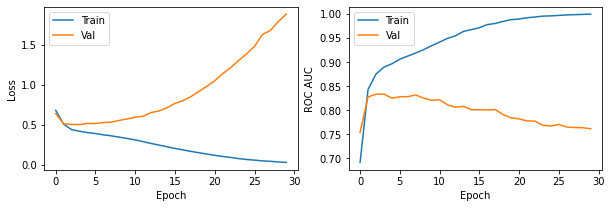

Нейронов в слое: 100
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.8335875995852416

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

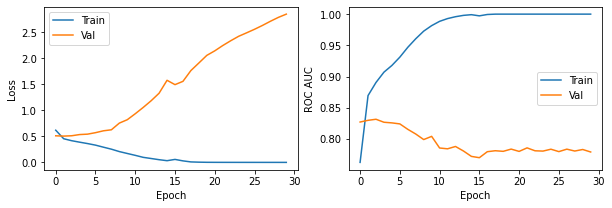

Нейронов в слое: 250
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.8316429130168806

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

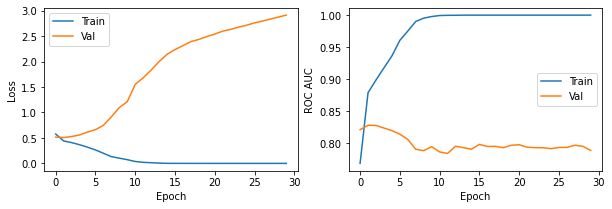

Нейронов в слое: 500
Кол-во слоёв: 5
Функция активации: relu
Лучший результат на валидации: 0.828031529397967

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

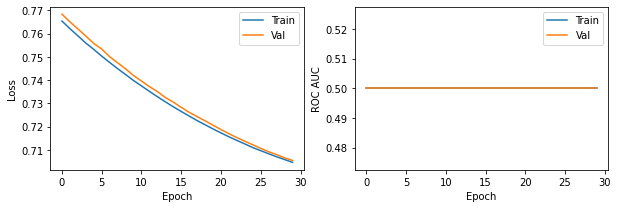

Нейронов в слое: 1
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.5

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

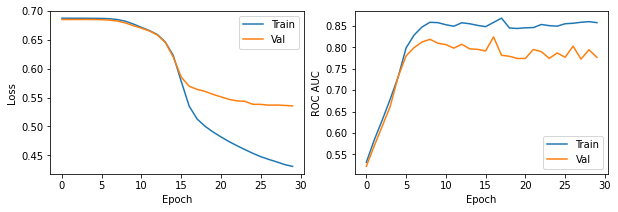

Нейронов в слое: 5
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.8238835044726376

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

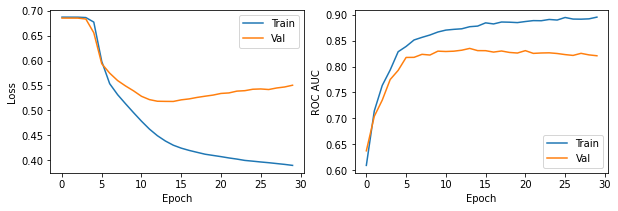

Нейронов в слое: 10
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.8352679040586298

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

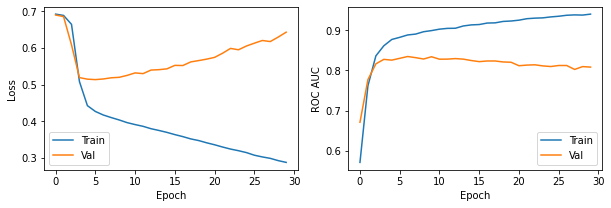

Нейронов в слое: 25
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.8347949543814372

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

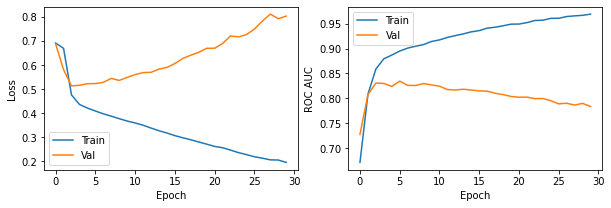

Нейронов в слое: 50
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.8346980581145251

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

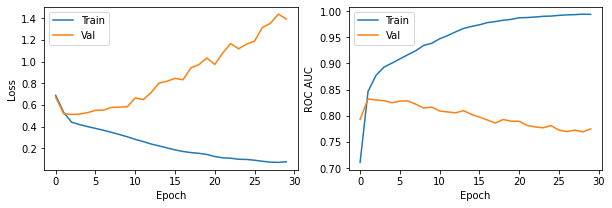

Нейронов в слое: 100
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.8321821885910176

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

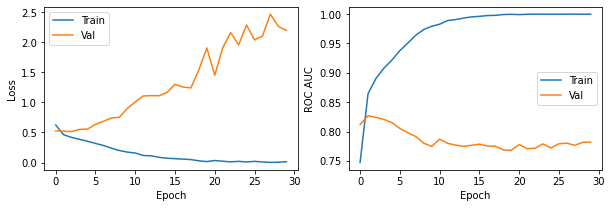

Нейронов в слое: 250
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.8269678131342355

---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


  0%|          | 0/1 [00:00<?, ?it/s]

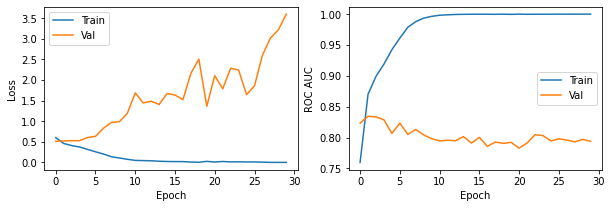

Нейронов в слое: 500
Кол-во слоёв: 10
Функция активации: relu
Лучший результат на валидации: 0.834552525402672

---



In [48]:
experiment_index = 4
num_epochs = 30
layer_counts = [1, 3, 5, 10] 
layer_sizes = [1, 5, 10, 25, 50, 100, 250, 500]
functions = [F.relu]
# functions = [F.relu, F.elu, torch.sigmoid, F.softsign, torch.tanh, F.hardshrink] 
for layer_count in tqdm_notebook(layer_counts):
  for layer_size in tqdm_notebook(layer_sizes):
    for function in tqdm_notebook(functions):
      roc_auc = test_layer_size(layer_size, activation=function, num_epochs=num_epochs, num_layers=layer_count);
      s, m = add_timing()
      results.loc[len(results)] = [layer_size, layer_count, get_f_name(function), num_epochs, roc_auc, experiment_index, s, m]
      timing_snapshot_extra('exp 4', layer_count, layer_size, num_epochs, function)
      print('\n---\n')

In [62]:
printt(get_result_info(results, 4))

,layer_size,layer_count,f_activation,num_epochs,roc_auc_score,time(sec),delta(min)
26,100,1,relu,30,0.841774,1893.770310,0.4
25,50,1,relu,30,0.840834,1866.789706,0.4
27,250,1,relu,30,0.840256,1920.682249,0.4
28,500,1,relu,30,0.840043,1947.448746,0.4
23,10,1,relu,30,0.840018,1813.170577,0.4
24,25,1,relu,30,0.839952,1840.079526,0.4
32,25,3,relu,30,0.838207,2077.183616,0.5
31,10,3,relu,30,0.837915,2044.566254,0.5
34,100,3,relu,30,0.836892,2141.286306,0.5
39,10,5,relu,30,0.835481,2317.505688,0.6


In [63]:
 printt(get_result_info(results))

,layer_size,layer_count,f_activation,num_epochs,roc_auc_score,experiment,time(sec),delta(min)
8,30,1,relu,15,0.842940,2,543.488536,0.2
4,50,1,relu,50,0.841980,1,397.478233,0.7
26,100,1,relu,30,0.841774,4,1893.770310,0.4
1,5,1,relu,50,0.841375,1,267.084850,0.7
6,250,1,relu,50,0.841180,1,485.457546,0.7
25,50,1,relu,30,0.840834,4,1866.789706,0.4
5,100,1,relu,50,0.840804,1,441.343115,0.7
27,250,1,relu,30,0.840256,4,1920.682249,0.4
28,500,1,relu,30,0.840043,4,1947.448746,0.4
23,10,1,relu,30,0.840018,4,1813.170577,0.4


In [51]:
timing_snapshot('exp 4 finished')

In [60]:
printt(timing)

,what,time(sec),delta(min)
0,begin,1.927120,0.0
1,load files,8.450523,0.1
2,extract_features,28.591335,0.3
3,features_creation,177.235957,2.5
4,before exp,177.720106,0.0
5,exp 1: num_layers=1; layer_size=1; num_epochs=...,223.496576,0.8
6,exp 1: num_layers=1; layer_size=5; num_epochs=...,267.105269,0.7
7,exp 1: num_layers=1; layer_size=10; num_epochs...,310.711783,0.7
8,exp 1: num_layers=1; layer_size=25; num_epochs...,353.627121,0.7
9,exp 1: num_layers=1; layer_size=50; num_epochs...,397.490132,0.7


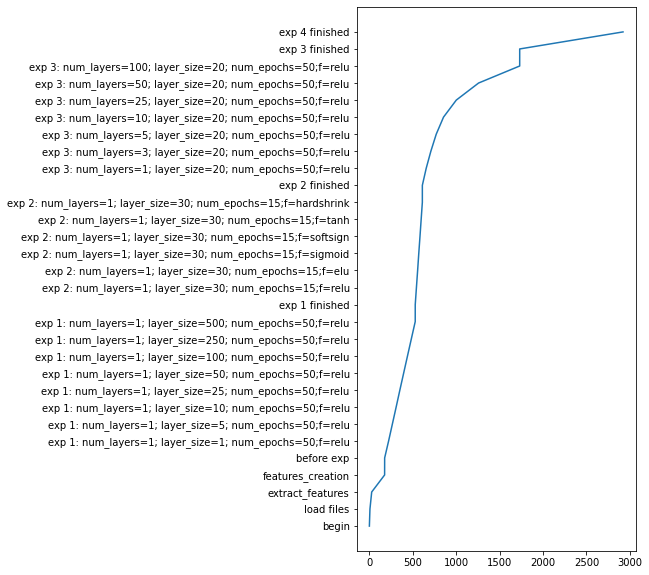

In [53]:
import matplotlib.pyplot as plt
import numpy as np
x = np.array(list(timing['time(sec)']))
y_text = list(timing['what'])
y = np.array(range(len(y_text)))
y
plt.rcParams["figure.figsize"] = (5,10)
plt.yticks(y, y_text)
plt.plot(x, y)
plt.show()

# Dropout

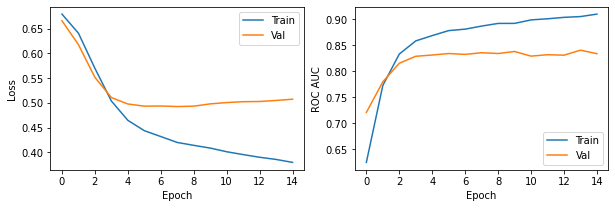

0.8409788920865818

In [54]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 100),
          nn.ReLU(),
          nn.Linear(100, 20),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.Linear(20, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

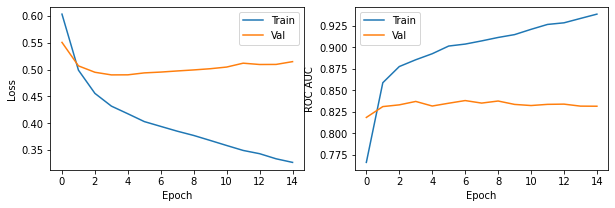

0.8379558624396957

In [55]:
model = nn.Sequential(
          nn.Linear(X_train.shape[1], 1000),
          nn.Dropout(p=0.2),
          nn.ReLU(),
          nn.Linear(1000, 1),
        )
model.to(device)
train_model(model, train_dataloader, val_dataloader, device=device, num_epochs=15, show=True)

дропаут ничего не дал

In [56]:
def download_to_kaggle(name, data_test, y_pred):
  submission = pd.DataFrame(index=data_test.index, data=y_pred, columns=['probability'])
  submission.to_csv(name)
  files.download(name)

In [57]:
from google.colab import files, output
output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

# Итог
В моём случае нейросети сработали лучше. Бустинг из первой лабы дал 0.8, а нейросеть - 0.84. В таблице выше представлены полные результаты разных конфигураций сети